# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4 
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt


Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?



Next, set up virtual display，and import all necessaary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [3]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [4]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [5]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [7]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [8]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [9]:
observation, reward, done, info = env.step(random_action)

In [10]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [11]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

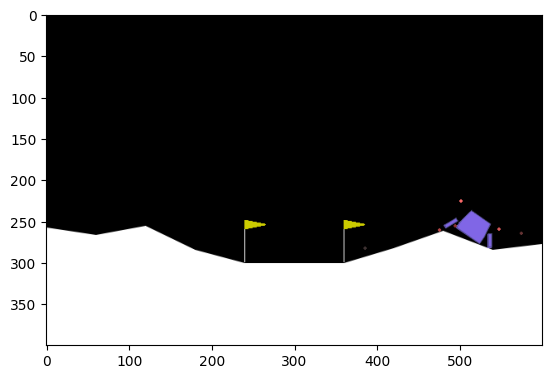

In [12]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [13]:
# class PolicyGradientNetwork(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(8, 16)
#         self.fc2 = nn.Linear(16, 16)
#         self.fc3 = nn.Linear(16, 4)

#     def forward(self, state):
#         hid = torch.tanh(self.fc1(state))
#         hid = torch.tanh(hid)
#         return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [14]:
# from torch.optim.lr_scheduler import StepLR
# class PolicyGradientAgent():
    
#     def __init__(self, network):
#         self.network = network
#         self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)
        
#     def forward(self, state):
#         return self.network(state)
#     def learn(self, log_probs, rewards):
#         loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
        
#     def sample(self, state):
#         action_prob = self.network(torch.FloatTensor(state))
#         action_dist = Categorical(action_prob)
#         action = action_dist.sample()
#         log_prob = action_dist.log_prob(action)
#         return action.item(), log_prob

Lastly, build a network and agent to start training.

In [15]:
# network = PolicyGradientNetwork()
# agent = PolicyGradientAgent(network)

## Actor-Critic

In [16]:
# from torch.optim.lr_scheduler import StepLR
# class ActorCritic(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(8, 16),
#             nn.Tanh(),
#             nn.Linear(16, 16),
#             nn.Tanh()
#         )
        
#         self.actor = nn.Linear(16, 4)
#         self.critic = nn.Linear(16, 1)
        
#         self.values = []
#         self.optimizer = optim.SGD(self.parameters(), lr=0.001)
#         self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, 
#                                                      base_lr=2e-4, max_lr=2e-3, 
#                                                      step_size_up=10, mode='triangular2')
        
        
#     def forward(self, state):
#         hid = self.fc(state)
#         self.values.append(self.critic(hid).squeeze(-1))
#         return F.softmax(self.actor(hid), dim=-1)
    
#     def learn(self, log_probs, rewards):
#         values = torch.stack(self.values)
#         loss = (-log_probs * (rewards - values.detach())).sum() + F.smooth_l1_loss(values, rewards)
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
#         self.scheduler.step()
        
#         self.values = []
        
#     def sample(self, state):
#         action_prob = self(torch.FloatTensor(state))
#         action_dist = Categorical(action_prob)
#         action = action_dist.sample()
#         log_prob = action_dist.log_prob(action)
#         return action.item(), log_prob
        

In [17]:
# agent = ActorCritic()

## DQN
- reference: https://zhuanlan.zhihu.com/p/514067644 

In [37]:
from collections import namedtuple

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class ReplayMemory: #Fixed-size buffer to store experience tuples.
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  
        self.memory = []  
        self.index = 0  
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        
    def push(self, state, action, state_next, reward): # Push a new experience to memory
        if len(self.memory) < self.capacity: # if still has capacity, initialize memory[index] to None
            self.memory.append(None)

        self.memory[self.index] = self.transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # circular index

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## DQN Agent
- https://blog.csdn.net/Raphael9900/article/details/128549103 

In [38]:
# from torch.optim.lr_scheduler import StepLR
class DQNAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, num_states, num_actions):
        """Initialize an Agent object."""
        
        self.num_states = num_states
        self.num_actions = num_actions
        
        # Replay memory
        self.memory_capacity = 10000
        self.memory = ReplayMemory(self.memory_capacity)
        
        # Q-Network
        self.main_q_network = DQN() 
        self.target_q_network = DQN()
        
        # optimizer
        self.optimizer = optim.RMSprop(self.main_q_network.parameters(), lr=1e-4)
        # self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=2e-4, max_lr=2e-3, step_size_up=10, mode='triangular2')
    
    def update_q_function(self):
        '''update q function'''
        
        # no enough samples, just return
        if len(self.memory) < BATCH_SIZE:
            return
        # If enough samples are available in memory, get random subset and learn
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()
        
        self.expected_state_action_values = self.get_expected_state_action_values()

        self.update_main_q_network()

    def make_minibatch(self):
        '''Creating a mini-batch'''

        transitions = self.memory.sample(BATCH_SIZE)

        Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        batch = Transition(*zip(*transitions))


        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''calculate Q（St,at）'''

        self.main_q_network.eval()
        self.target_q_network.eval()

        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)

        non_final_mask = torch.BoolTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # set all state to 0
        next_state_values = torch.zeros(BATCH_SIZE)

        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).max(1)[0].detach()
        # DQN formula
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values
        
        return expected_state_action_values 
        
    def get_action(self, state, episode, test=False):
        """Returns actions for given state as per current policy."""
        if test:
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(torch.from_numpy(state).unsqueeze(0)).max(1)[1].view(1, 1)
            return action.item()
        
        global steps_done
        # Epsilon-greedy policy
        #epsilon = episode
        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = EPS_END + (EPS_START - EPS_END) * \
                np.exp(-1. * steps_done / EPS_DECAY)
        #print('epsilon', epsilon)
        
        steps_done += 1
        
        if epsilon <= np.random.uniform(0, 1):
            #print('use max')
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(state).max(1)[1].view(1, 1)
        else:
            #print('random')
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  
            
        return action

    def update_main_q_network(self):
        
        '''update main q net'''

        # set train mode
        self.main_q_network.train()
        # Hurberloss function
        # expected_state_action_values (minbatch,)->(minbatchx1)

        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # update
        self.optimizer.zero_grad()  # reset gradient
        loss.backward()  # backpropagation
        for param in self.main_q_network.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()
        # self.scheduler.step()


    def memorize(self, state, action, state_next, reward):
        '''save state, action, state_next, reward into replay memory'''
        self.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        
        '''synchronize Target Q-Network to Main Q-Network'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())  

In [39]:
network = DQN()
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

In [40]:
# from torch.optim.lr_scheduler import StepLR

# class Action(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = nn.Linear(8, 64)
#     self.fc2 = nn.Linear(64, 64)
#     self.fc3 = nn.Linear(64, 4)

#   def forward(self, state):
#       hid = torch.tanh(self.fc1(state))
#       hid = torch.tanh(self.fc2(hid))
#       return F.softmax(self.fc3(hid), dim=-1)
  
  
# class Critic(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = nn.Linear(8, 64)
#     self.fc2 = nn.Linear(64, 64)
#     self.fc3 = nn.Linear(64, 4)

#   def forward(self, state):
#       hid = torch.tanh(self.fc1(state))
#       hid = torch.tanh(self.fc2(hid))
#       return F.softmax(self.fc3(hid), dim=-1)
  

# class DQN():
#     def __init__(self,action,critic):
#         self.action_net = action
#         self.critic_net = critic
        
#         self.optimizer = optim.AdamW(self.action_net.parameters(), lr=5e-4) #originally is Adam
#         self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=2e-4, max_lr=2e-3, step_size_up=10, mode='triangular2')
        
#         self.critic_net.load_state_dict(self.action_net.state_dict()) 
#         self.critic_net.eval() 
        
#     def forward(self, state):
#         return self.action_net(state)
    
#     def learn(self, state_action_values, expected_state_action_values,batch):
#         loss = torch.zeros(1)
        
#         for i in range(len(state_action_values)):
#             loss += F.smooth_l1_loss(state_action_values[i], expected_state_action_values[i])
#         self.optimizer.zero_grad()
#         loss.backward()
        
#         self.optimizer.step()
#         self.scheduler.step()
    
#         if batch%10 == 9:
#             self.critic_net.load_state_dict(self.action_net.state_dict())
            
#     def sample(self, state):
#         r = torch.randn(1)
#         if r > 0.2:
#             with torch.no_grad():
#                 state = torch.FloatTensor(state).to(device)
#                 return self.action_net(state).argmax().item()
#         else:
#             return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long).item()

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts.  
Reference is the same.


> for DQN

In [41]:
EPISODE_PER_BATCH = 5
NUM_BATCH = 600        
BATCH_SIZE = 32
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
GAMMA = 0.99

best_score = 0
best_batch = 0

# set the training mode
agent.main_q_network.train()
agent.target_q_network.train()
steps_done = 0

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    rewards = []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        observation = env.reset() 
        state = observation  
        state = torch.from_numpy(state).type(
                torch.FloatTensor)
        state = torch.unsqueeze(state, 0)
        total_reward, total_step = 0, 0

        while True:

            action = agent.get_action(state, batch)  
            observation_next, reward, done, _ = env.step(action.item())

            total_reward += reward
            total_step += 1
            rewards.append(reward) 
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            
            # boss : implement DQN
            if done:
                state_next = None  
            else:
                state_next = observation_next  
                state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  
                state_next = torch.unsqueeze(state_next, 0)
                
            agent.memorize(state, action, state_next, torch.FloatTensor([reward]))
            
            agent.update_q_function()
            
            state = state_next
        
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
                

    #print(f"rewards looks like ", np.shape(rewards))      
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    agent.update_target_q_function()
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(np.array(rewards)).size())


    ### testing

    fix(env, seed)
    agent.main_q_network.eval() 
    NUM_OF_TEST = 5 # Do not revise it !!!!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()

        #img = plt.imshow(env.render(mode='rgb_array'))

        total_reward = 0

        done = False
        while not done:
            action = agent.get_action(state, episode=i, test=True)
            actions.append(action)
            state, reward, done, _ = env.step(action)

            total_reward += reward
            
        print(total_reward)
        test_total_reward.append(total_reward)

        action_list.append(actions)
        print("length of actions is ", len(actions))
        
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
    if np.mean(test_total_reward) > 250:
        distribution = {}
        for actions in action_list:
            for action in actions:
                if action not in distribution.keys():
                    distribution[action] = 1
                else:
                    distribution[action] += 1
                    
        PATH = "Action_List_test" + str(batch) + ".npy" 
        np.save(PATH ,np.array(action_list)) 
        
        if np.mean(test_total_reward) > best_score:
            best_score = np.mean(test_total_reward)
            best_batch = batch
            print('Improve to score %.2f at batch %d'% (best_score, best_batch ))

  0%|          | 0/600 [00:00<?, ?it/s]

torch.from_numpy(rewards) looks like  torch.Size([590])
-433.39037110942786
length of actions is  78
-251.44489637172776
length of actions is  105
-160.14698323218713
length of actions is  80
-138.42770454733193
length of actions is  80
-75.65927283442142
length of actions is  160
Your final reward is : -211.81
torch.from_numpy(rewards) looks like  torch.Size([1494])
-76.05466074140702
length of actions is  114
-130.52175748193156
length of actions is  1000
-171.40800419825675
length of actions is  215
-212.41146666366666
length of actions is  160
-97.07558335921664
length of actions is  1000
Your final reward is : -137.49
torch.from_numpy(rewards) looks like  torch.Size([1696])
-265.7831182452813
length of actions is  85
-485.3474027006262
length of actions is  210
-173.64272164835734
length of actions is  1000
-104.73683502114832
length of actions is  198
-368.96787844821563
length of actions is  226
Your final reward is : -279.70


KeyboardInterrupt: 

> for actor

In [ ]:
# agent.train()  # Switch network into training mode 
# EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
# NUM_BATCH = 600       # totally update the agent for 400 time
# rate = 0.985
# avg_total_rewards, avg_final_rewards = [], []

# prg_bar = tqdm(range(NUM_BATCH))
# for batch in prg_bar:

#     log_probs, rewards = [], []
#     total_rewards, final_rewards = [], []

#     # collect trajectory
#     for episode in range(EPISODE_PER_BATCH):
        
#         state = env.reset()
#         total_reward, total_step = 0, 0
#         seq_rewards = []
#         while True:

#             action, log_prob = agent.sample(state) # at, log(at|st)
#             next_state, reward, done, _ = env.step(action)

#             log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
#             seq_rewards.append(reward)
#             state = next_state
#             total_reward += reward
#             total_step += 1
#             #rewards.append(reward) # change here
#             # ! IMPORTANT !
#             # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
#             #                                                         rewards :     r1, r2 ,r3 ......
#             # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
#             #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
#             # boss : implement Actor-Critic
#             if done:
#                 final_rewards.append(reward)
#                 total_rewards.append(total_reward)
#                 # calculate accumulative rewards
#                 for i in range(2, len(seq_rewards)+1):
#                     seq_rewards[-i] += rate * (seq_rewards[-i+1])
#                 rewards += seq_rewards
                
#                 break

 
#     print(f"rewards looks like ", np.shape(rewards))  
#     print(f"log_probs looks like ", len(log_probs))     
#     # record training process
#     avg_total_reward = sum(total_rewards) / len(total_rewards)
#     avg_final_reward = sum(final_rewards) / len(final_rewards)
#     avg_total_rewards.append(avg_total_reward)
#     avg_final_rewards.append(avg_final_reward)
#     prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

#     # update agent
#     # rewards = np.concatenate(rewards, axis=0)
#     rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
#     agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
#     print("logs prob looks like ", torch.stack(log_probs).size())
#     print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
fix(env, seed)
# agent.network.eval()  # set the network into evaluation mode
agent.eval()
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


In [ ]:
print(np.mean(test_total_reward))

Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

## Saving the result of Model Testing


In [ ]:
PATH = "/home/wmnlab/Documents/sheng-ru/bai/test3/Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

# agent.network.eval()  # set network to evaluation mode
agent.eval()

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
